# Prepare train/test datasets

1. Load the .csv/image data from the PyBlastAfterglow collated data
2. Clear/Impute data
3. Format data so it has the following shape
```Python

light_curve = np.array(
[
[.1, .2, ..., .3], # Light curve 0 (parameter set 0)
[.1, .2, ..., .3], # Light curve 1 (parameter set 1)
[..., ..., ...  ],
[.1, .2, ..., .3], # Light curve N (parameter set N)
])

parameter_sets = np.array(
[
[1, 2, 3, ..., 4], # parameters for light curve 0
[1, 2, 3, ..., 4], # parameters for light curve 1
[..., ..., ...  ],
[1, 2, 3, ..., 4], # parameters for light curve N
])
```

__NOTE__: The first index is the index of the lightcurve and a parameter set in the overall.  
This index will be used to take a subset of lightcurves and parameter sets for mini-batch training in the `torch.DataLoader()`

In [18]:
import pandas as pd
import os.path
import os
import h5py
import numpy as np
import tqdm
import itertools
import matplotlib.pyplot as plt
from matplotlib import colors

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.empty_cache()
    

# Select Simulation To Process

In [2]:
AFGRUNDIR = "/media/vsevolod/T7/work/prj_kn_afterglow/"
sim = {}; sim["name"] = "SFHoTim276_13_14_0025_150mstg_B0_HLLC"
collated_file_path = AFGRUNDIR + sim["name"] + '/' + "collated.csv"
outdir = os.getcwd() + '/'

assert os.path.isfile(collated_file_path), "Collated file not found"
df = pd.read_csv(collated_file_path, index_col=0)
print(f"File loaded: {collated_file_path} {print(df.info(memory_usage='deep'))}")

<class 'pandas.core.frame.DataFrame'>
Index: 6480000 entries, 0 to 6479999
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   eps_e      float64
 1   eps_b      float64
 2   eps_t      float64
 3   p          float64
 4   theta_obs  float64
 5   n_ism      float64
 6   freq       float64
 7   time       float64
 8   flux       float64
dtypes: float64(9)
memory usage: 494.4 MB
None
File loaded: /media/vsevolod/T7/work/prj_kn_afterglow/SFHoTim276_13_14_0025_150mstg_B0_HLLC/collated.csv None


In [3]:
target = "flux"

In [4]:
def _visualize_df(df:pd.DataFrame, name:str):
    print(f"\t> Visualizing {name} Shape: {df.shape}")

    display(df.head(2))

    print(f"\t Duplicated_rows: {df.duplicated().sum()}")

    # check df properties
    def analyze_df(df : pd.DataFrame)->pd.DataFrame:
        res = pd.DataFrame({
            "is_unique": df.nunique() == len(df),
            "unique": df.nunique(),
            "with_nan":df.isna().any(),
            "percent_nan":round((df.isnull().sum()/len(df))*100,4),
            "min":df.min(),
            "max":df.max(),
            "mean":df.mean(),
            "dtype":df.dtypes
        })
        return res
    print(f"\t> Numeric features: {df.select_dtypes(exclude='object').shape[1]} \n"
          f"{df.select_dtypes(exclude='object').keys()}")
    print(f"\t> Object features: {df.select_dtypes(exclude='number').shape[1]} \n"
          f"{df.select_dtypes(exclude='number').keys()}")
    print(f"\t Analyzing {name} Summary:")
    metadata = analyze_df(df=df)
    return metadata
metadata = _visualize_df(df=df, name=sim["name"])
display(metadata)

	> Visualizing SFHoTim276_13_14_0025_150mstg_B0_HLLC Shape: (6480000, 9)


,eps_e,eps_b,eps_t,p,theta_obs,n_ism,freq,time,flux
0,0.001,0.001,0.01,2.2,0.0,0.001,2.400000e+09,100000.000000,7.278929e-11
1,0.001,0.001,0.01,2.2,0.0,0.001,2.400000e+09,106332.657164,8.460537e-11


	 Duplicated_rows: 0
	> Numeric features: 9 
Index(['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq', 'time',
       'flux'],
      dtype='object')
	> Object features: 0 
Index([], dtype='object')
	 Analyzing SFHoTim276_13_14_0025_150mstg_B0_HLLC Summary:


,is_unique,unique,with_nan,percent_nan,min,max,mean,dtype
eps_e,False,5,False,0.0,1.000000e-03,5.000000e-01,1.322000e-01,float64
eps_b,False,5,False,0.0,1.000000e-03,5.000000e-01,1.322000e-01,float64
eps_t,False,4,False,0.0,1.000000e-02,1.000000e+00,4.025000e-01,float64
p,False,4,False,0.0,2.200000e+00,2.800000e+00,2.500000e+00,float64
theta_obs,False,3,False,0.0,0.000000e+00,1.570796e+00,7.853982e-01,float64
n_ism,False,6,False,0.0,1.000000e-03,1.000000e+00,2.768333e-01,float64
freq,False,6,False,0.0,2.400000e+09,9.300000e+10,3.123333e+10,float64
time,False,150,False,0.0,1.000000e+05,9.404449e+08,1.052639e+08,float64
flux,True,6480000,False,0.0,4.115669e-13,1.015367e+02,1.489473e-01,float64


# Select and tansform features

In [5]:
# Set target
metadata["target"] = "flux"

In [6]:
# Print total number of lightcurves
n_curves = np.prod([metadata["unique"][key] for key in df.columns if key not in ["flux","time"]])
n_times = metadata["unique"]["time"]
print(f"total number of light curves: {n_curves} times: {n_times}")

total number of light curves: 43200 times: 150


In [7]:
unique_times = np.array([10, 20, 30])
physical_parameters = np.array([1,2,3,4,5])
all_data_input = np.hstack((
    np.repeat(physical_parameters.reshape(1, -1), len(unique_times), axis=0),
    unique_times.reshape(-1, 1)
))
print(all_data_input.shape)
print(all_data_input)

(3, 6)
[[ 1  2  3  4  5 10]
 [ 1  2  3  4  5 20]
 [ 1  2  3  4  5 30]]


# Create Numpy Arrays from Dataframe

In [1]:
# Prepare data in numpy arrays
features_names = [col for col in list(df.columns) if col not in [target, "time"]]
print(f"Target name: '{target}' features_names: {features_names}")

def LcCollatedDataFrameToNumpyArray(df:pd.DataFrame, metadata:pd.DataFrame,target="flux",time="time"):

    n_curves = np.prod([metadata["unique"][key] for key in features_names])#df.columns if key not in ["flux","time"]])
    n_times = metadata["unique"]["time"]
    print(f"Total number of light curves: {n_curves} times: {n_times}")

    grouped = df.groupby(features_names)
    pars = np.vstack([np.array(key) for key, val in grouped.groups.items()])
    lcs  = np.vstack([np.array(df[target].iloc[val]) for key, val in grouped.groups.items()])
    times= np.array(np.array(df[time].unique()))
    assert len(times) == len(lcs[0])
    assert n_curves == len(lcs)
    return (lcs, pars, times)

lcs, pars, times = LcCollatedDataFrameToNumpyArray(df, metadata)  

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")

with h5py.File(outdir+"X.h5","w") as f:
    f.create_dataset("X", data=lcs, dtype=np.float32)
    f.create_dataset("time", data=times, dtype=np.float64)

with h5py.File(outdir+"Y.h5","w") as f:
    f.create_dataset("Y", data=pars, dtype=np.float32)
    f.create_dataset("keys", data=np.array(features_names,dtype="S"))
print("Data saved as .h5 files")

NameError: name 'df' is not defined

In [9]:
# Read data from local
with h5py.File(outdir+"X.h5","r") as f:
    lcs = np.array(f["X"])
    times = np.array(f["time"])

with h5py.File(outdir+"Y.h5","r") as f:
    pars = np.array(f["Y"])
    features_names = list([str(val.decode("utf-8")) for val in f["keys"]])

print(f"lcs={lcs.shape}, pars={pars.shape}, times={times.shape}")
print(f"lcs={lcs.min()}, {lcs.max()}, pars={pars.min()} {pars.max()}, times={times.shape}")
print(features_names)

lcs=(43200, 150), pars=(43200, 7), times=(150,)
lcs=4.1156688517299256e-13, 101.53666687011719, pars=0.0 92999999488.0, times=(150,)
['eps_e', 'eps_b', 'eps_t', 'p', 'theta_obs', 'n_ism', 'freq']


# Examine Distribution

In [13]:
from train import LightCurveDataset
dataset = LightCurveDataset(pars, lcs, times, device=device, lc_transform_method="minmax")
# dataset2 = LightCurveDataset(pars, lcs, times, device=device, lc_transform_method="standard")

Text(0.5, 1.0, 'Data distribution')

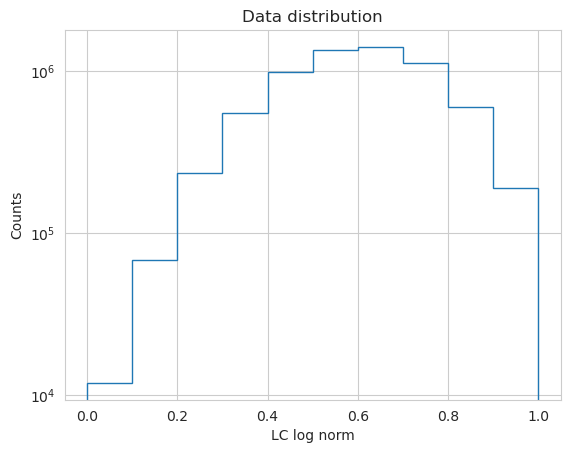

In [16]:
counts, bins = np.histogram(dataset.lcs_log_norm)
plt.stairs(counts, bins)
plt.yscale("log")
plt.xlabel("LC log norm")
plt.ylabel("Counts")
plt.title("Data distribution")


# LC exploration

In [17]:
# collect peak times and peak fluxes
keys = list(df.keys())
keys.remove("time")
keys.remove("flux")
idx = df.groupby(keys)["flux"].idxmax()
print(idx)

max_fluxes = df.loc[idx]
print(max_fluxes.shape)
print(max_fluxes.head())

eps_e  eps_b  eps_t  p    theta_obs  n_ism  freq        
0.001  0.001  0.01   2.2  0.000000   0.001  2.400000e+09        113
                                            8.000000e+09        263
                                            1.600000e+10        413
                                            2.700000e+10        563
                                            4.100000e+10        713
                                                             ...   
0.500  0.500  1.00   2.8  1.570796   1.000  8.000000e+09    6479309
                                            1.600000e+10    6479456
                                            2.700000e+10    6479603
                                            4.100000e+10    6479751
                                            9.300000e+10    6479899
Name: flux, Length: 43200, dtype: int64
(43200, 9)
     eps_e  eps_b  eps_t    p  theta_obs  n_ism          freq          time  \
113  0.001  0.001   0.01  2.2        0.0  0.001  2.400000e+09  1.

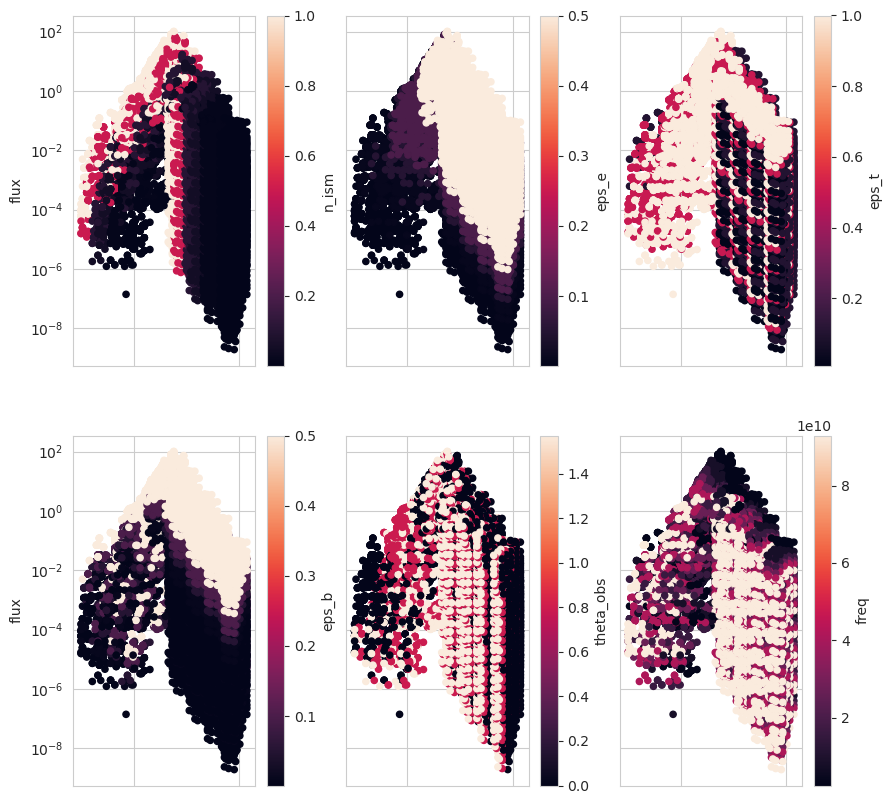

In [21]:
# PLOT ALL light curves peak times and fluxes
def plot_all_lcs_peaks(max_fluxes : pd.DataFrame):
    fig,axes = plt.subplots(ncols=3,nrows=2,sharex="all",sharey="all",figsize=(10,10))
    max_fluxes.plot.scatter(ax=axes[0][0], x="time",y="flux",c="n_ism",colorbar=True,norm=colors.Normalize())
    max_fluxes.plot.scatter(ax=axes[0][1], x="time",y="flux",c="eps_e",colorbar=True,norm=colors.Normalize())
    max_fluxes.plot.scatter(ax=axes[0][2], x="time",y="flux",c="eps_t",colorbar=True,norm=colors.Normalize())
    max_fluxes.plot.scatter(ax=axes[1][0], x="time",y="flux",c="eps_b",colorbar=True,norm=colors.Normalize())
    max_fluxes.plot.scatter(ax=axes[1][1], x="time",y="flux",c="theta_obs",colorbar=True,norm=colors.Normalize())
    max_fluxes.plot.scatter(ax=axes[1][2], x="time",y="flux",c="freq",colorbar=True,norm=colors.Normalize())
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
plot_all_lcs_peaks(max_fluxes)